# Purpose
This notebook contains sample code to evaluate calibration of a laser for optimal ion response.

# Summary
The code is organized to support modularity between the ion response behaviour and the calibration mechanism; each having their own abstract base class. Different implementation of these can be used to model different ion responses, and different algorithms to find optimal positions. The test code can be generic to the base class allowing high reuse between test, and an easy path to switch between models and scan algorithms.

# Details

## Ion Response

These classes determine what response is producted for the current mirror position.

1. mirror mount positions go from 0 to 1 (or any arbitrary continuous range really)
2. ion responses go from 0 to 100 photons per measurement round (or any arbitrary , small,
integer range)

## Calibration/Scan

These classes control what positions to try next via an iterator and how to determine the best position.

In [18]:
from typing import List, Dict, Iterator
from abc import ABC, abstractmethod
import math
from operator import itemgetter

import scipy.stats as stats
from scipy import optimize

import numpy
import matplotlib.pyplot as plt
from matplotlib.figure import Figure


class IonSystem(ABC):
    """
    Abstract base class for an ion system.

    This controls what response is produced at the current mirror position.

    """
    _max_ion_response = 100

    @abstractmethod
    def move_mirror_to_position(self, pos: float) -> None:
        """
        Move position to pos. 0-1

        """
        ...

    @abstractmethod
    def measure_ion_response(self) -> int:
        """
        Return the ion response 0 to _max_ion_response

        """
        ...

class GaussianIonSystem(IonSystem):
    """
    Ion System the follows a ideal gaussian curve.

    """
    def __init__(self, peak_location: float, variance: float):
        # define constants
        self.peak_location: float = peak_location
        self.variance: float = variance
        self.pos: float = 0.

    @property
    def sigma(self) -> float:
        return math.sqrt(self.variance)

    def move_mirror_to_position(self, pos: float) -> None:
        """
        Move position to pos. 0-1

        """
        self.pos = pos

    def measure_ion_response(self) -> int:
        """
        Return the ion response 0 to _max_ion_response

        """
        return round(
            self._max_ion_response *
            stats.norm.pdf(self.pos, self.peak_location, self.sigma)
            )

class MeasureControlSystem(ABC):
    """
    Base class to define the positions to measure and how to pick the best postion.
    
    """

    #keep track of what was recorded.
    previous_positions: List[float]
    previous_response: List[int]
    step_index: int

    def __init__(self):
        self._initialize_search()

    def _initialize_search(self) -> None:
        self.previous_positions = []
        self.previous_response = []
        self.step_index = 0

    @abstractmethod
    def pick_best_position(self) -> float:
        """
        return the best position based off the points collected.

        """
        ...

    @property
    @abstractmethod
    def search_complete(self) -> bool:
        """
        Return true when search is complete.

        """
        ...

    def next_position(self) -> float:
        """
        Private next postiion that also records the point.

        """
        cur_pos = self._next_position()
        self.previous_positions.append(cur_pos)
        self.step_index += 1
        return cur_pos

    @abstractmethod
    def _next_position(self) -> float:
        """
        Iterator to produce points.

        """
        ...

    def record_response(self, response: float) -> None:
        """
        Record what the response was for the previous points.

        Points must be recorded in the order measured.
        
        """
        self.previous_response.append(response)

    def __iter__(self) -> Iterator[float]:
        self._initialize_search()
        return self

    def __next__(self) -> float:
        if self.search_complete:
            raise StopIteration
        return self.next_position()
    
    def scan(self, ion_system: IonSystem) -> float:
        for cur_position in self:
            ion_system.move_mirror_to_position(cur_position)
            self.record_response(ion_system.measure_ion_response())
   
        return self.pick_best_position()


class LinearSearchGaussianPicker(MeasureControlSystem):
    """
    Measure control system that does a linear search (scan) and picks the best position based off a gaussian fit.

    """

    def __init__(self, num_steps = 100):
        self.num_steps = num_steps
        self._positions = numpy.linspace(0,1,self.num_steps)

    def pick_best_position(self) -> float:
        """
        This picker assumes a gaussian curve, so we use a fit match to that.
        
        """
        ion_response_list = zip(self.previous_positions, self.previous_response)
        first_guess_mean = sorted(ion_response_list, key = itemgetter(1), reverse=True)[0][0]

        def gaussian(x, amplitude, mean, stddev):
            return amplitude * numpy.exp(-((x - mean) / 4 / stddev)**2)

        (_, mean, _), _ = optimize.curve_fit(gaussian, self.previous_positions, self.previous_response, p0=[100, first_guess_mean, 1])
        return mean

    @property
    def search_complete(self) -> bool:
        """
        Return true when search is complete.

        """
        return len(self.previous_positions) >= self.num_steps

    def _next_position(self) -> float:
        """
        Iterator to produce points based off what has been recorded.

        """
        return self._positions[self.step_index]

In [31]:
def evaluate_locator(
        cur_ion_sys: IonSystem, 
        measure_controller: MeasureControlSystem,
        expected_position: float,
        ) -> float:
    """
    Evaluate how good the method is.
    
    """
    scan_result = measure_controller.scan(cur_ion_sys)
    error = abs(scan_result - expected_position)
    return error

def plot_evaluation(
        cur_ion_sys: IonSystem, 
        measure_controller: MeasureControlSystem,
        expected_position: float,
        ) -> Figure:
    """
    Evaluate how good the method is.
    
    """

    scan_result = measure_controller.scan(cur_ion_sys)
    error = abs(scan_result - expected_position)
    
    ion_responses: List[int] = []
    pos_scan = numpy.arange(0, 1, .0001)
    for pos in pos_scan:
        cur_ion_sys.move_mirror_to_position(pos)
        ion_response = cur_ion_sys.measure_ion_response()
        ion_responses.append(ion_response)

    fig, axes = plt.subplots(1,1)
    axes.plot(pos_scan, ion_responses, label="Measured Response")
    axes.axvline(scan_result, color='blue', label='Peak Detect')
    axes.axvline(expected_position, linestyle='dashed', color='gray', label='Peak Actual')
    # dont use percent error because peak could be near zero.
    axes.set_title(f'Error: {error:.02e}')
    axes.legend()
    return fig


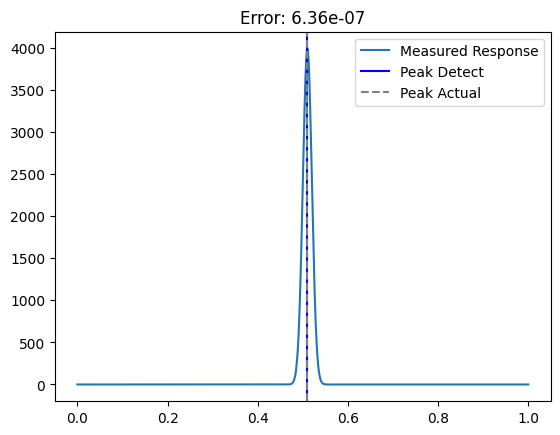

In [37]:
peak_location = .51
variance=.0001
num_scan_steps = 100
cur_ion_sys = GaussianIonSystem(peak_location=peak_location, variance=variance)
measure_controller = LinearSearchGaussianPicker(num_steps = num_scan_steps)

fig = plot_evaluation(
    cur_ion_sys=cur_ion_sys,
    measure_controller=measure_controller,
    expected_position=peak_location,
    )

fig.show()

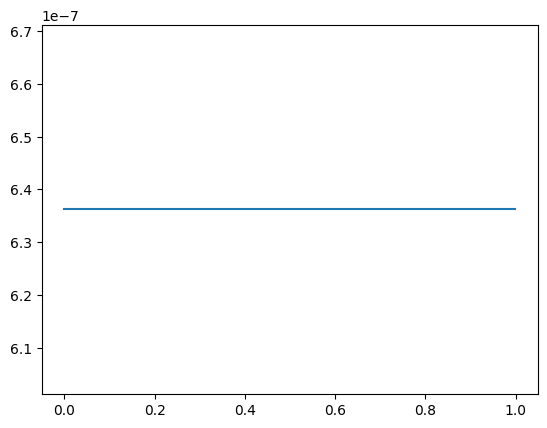

In [25]:
peak_locations = numpy.arange(0, 1, .001)
error: List[float] = []
num_scan_steps = 100

measure_controller = LinearSearchGaussianPicker(num_steps = num_scan_steps)

for cur_peak_location in peak_locations:
    variance=.0001
    cur_ion_sys = GaussianIonSystem(peak_location=peak_location, variance=variance)

    error.append(evaluate_locator(
        cur_ion_sys=cur_ion_sys,
        measure_controller=measure_controller,
        expected_position=peak_location,
        ))

fig, axes = plt.subplots(1,1)
axes.plot(peak_locations, error)
fig.show()